# **Práctica 3**
Lucía Pazos Santiago, Anxo Trillo Santamaría, Javier Ares Vila

In [1]:
# Importaciones necesarias
try:
    import torch
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from torchvision.transforms import ToTensor
    import torch.nn as nn
    import torch.nn.functional as F
except ImportError:
    !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu
    import torch
    from torch.utils.data import DataLoader
    from torchvision import datasets
    from torchvision.transforms import ToTensor
    import torch.nn as nn
    import torch.nn.functional as F
    
try:
    from skimage.feature import hog
    from skimage.color import rgb2gray
except ImportError:
    !pip3 install scikit-image
    from skimage.feature import hog
    from skimage.color import rgb2gray
!pip3 install matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import confusion_matrix 
import numpy as np
import random
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from torchvision.datasets import ImageFolder
import torchvision
from torchvision import transforms
import itertools

torch.manual_seed(1)
random.seed(1)
np.random.seed(1)

Looking in indexes: https://download.pytorch.org/whl/cpu
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 41.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 MB 54.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 43.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.2
    Uninstalling sympy-1.13.2:
      Successfully uninstalled sympy-1.13.2


## Arquitectura MLP modular

In [2]:
class MLP(nn.Module):
    def __init__(self, input_neurons, output_neurons, hidden_layers):
        super(MLP, self).__init__()
        self.input_neurons=input_neurons
        self.output_neurons=output_neurons
        self.hidden_layers=hidden_layers

        self.flatten = nn.Flatten()

        layers=[]
        prev_neurons=input_neurons
        if isinstance(hidden_layers,list):
            for i in hidden_layers:
                layers.append(nn.Linear(prev_neurons,i))
                layers.append(nn.ReLU())
                layers.append(nn.Dropout(0.5))
                prev_neurons=i
        else:
            print("ERROR DE FORMATO, PASALE UNA LIST COMO HIDDENLAYERS")
        
        layers.append(nn.Linear(prev_neurons,output_neurons))

        self.hiddenlayer_stack = nn.Sequential(*layers)


    def forward(self, x):

        x=self.flatten(x)
        salida=self.hiddenlayer_stack(x)
        return salida

In [ ]:
# Ejemplo de uso 
mlp = MLP(
    input_neurons=128*128*3,
    output_neurons=10,
    hidden_layers=[64,32]
)

# Función para contar los parámetros del modelo
def get_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"O modelo ten {get_parameters(mlp):,} parámetros")

O modelo ten 3,148,202 parámetros


## Arquitectura CNN modular

In [20]:
# Definición de la clase CNN
class CNN(nn.Module):

    # input_channels: número de canales de entrada 
    # conv_layers: número de capas convolucionales
    # first_conv_filters: num filtros primera capa, se duplicarán en cada capa
    # con_kernel_size: tam filtros convolucionales (cuadrados)
    # batch_norm: booleano para usar normalización por lotes
    # hidden_mlp_layers: número de neuronas en la capa oculta de la red MLP
    # output_neurons: número de neuronas de salida
    # input_size: tamaño de las imagenes que le vamos a pasar
    def __init__(self, input_channels, conv_layers, first_conv_filters, conv_kernel_size, batch_norm, hidden_mlp_layers, output_neurons,input_size):

        # Construtor 
        super(CNN, self).__init__()  

        def conv_size(size): #Funcion que calcula el tamaño resultante de la convolucion
            return (size - conv_kernel_size + 1) 

        def pool_size(size, kernel_size=2, stride=2, padding=0): #Funcion que calcula el tamaño resultante del pooling
            return (size - kernel_size + 2 * padding) // stride + 1

        current_channels = input_channels
        current_filters = first_conv_filters
        
        if isinstance(input_size,list): #Asumimos que las imágenes son cuadradas
            current_size = input_size[0]
        else:
            current_size=input_size

        # Arrays auxiliares
        layers = [] # Contiene las capas

        # Definición de capas según los parámetros
        for _ in range(conv_layers): # Bucle para el número de capas convolucionades pasadas por parámetro
            layers.append(nn.Conv2d(in_channels=current_channels, out_channels=current_filters, kernel_size=conv_kernel_size))
            current_size = conv_size(current_size) #Se calcula el tamaño resultante en una dimensión (el total sería size * size * channels)

            if batch_norm: # Si se usa normalización por lotes, se añade la capa de normalización
                layers.append(nn.BatchNorm2d(current_filters)) # Capa de normalización por lotes
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0)) # Capa de max pooling
            current_size = pool_size(current_size) #Se calcula el tamaño resultante en una dimensión (el total sería size * size * channels)

            layers.append(nn.ReLU()) # Capa de activación ReLU
            current_channels = current_filters # Actualiza el número de canales de entrada para la siguiente capa convolucional

            current_filters *= 2 # Duplica el número de filtros para la siguiente capa convolucional

        # Capa de convolución final
        self.conv = nn.Sequential(*layers) # Capa convolucional compuesta por las capas definidas en el bucle anterior
        
        # Capa de aplanamento
        self.flatten = nn.Flatten()

        # Cálculo del tamaño de la salida de la última capa convolucional
        flattened_size = current_channels * current_size * current_size 
        
        # MLP
        layers_mlp = []
        prev_neurons=flattened_size
        if isinstance(hidden_mlp_layers,list):
            for i in hidden_mlp_layers:
                layers_mlp.append(nn.Linear(prev_neurons,i)) # Se añade una capa con las neuronas de entrada de la capa anterior y las de salida de la actual
                layers_mlp.append(nn.ReLU())
                prev_neurons=i
        else:
            print("ERROR DE FORMATO, PASALE UNA LIST COMO HIDDENLAYERS")

        layers_mlp.append(nn.Linear(prev_neurons,output_neurons))
        
        self.mlp = nn.Sequential(*layers_mlp)

    def forward(self, x):

        x = self.conv(x)
        x = self.flatten(x)
        x = self.mlp(x)

        return x   

In [21]:
# Ejemplo de uso 
cnn = CNN(
    input_channels=3,
    conv_layers=2,
    first_conv_filters=32,
    conv_kernel_size=3,
    batch_norm=True,
    hidden_mlp_layers=[128],
    output_neurons=10,
    input_size=[128,128]
)

# Función para contar los parámetros del modelo
def get_parameters(model):
    return sum(p.numel() for p in model.parameters())

print(f"O modelo ten {get_parameters(cnn):,} parámetros")

O modelo ten 7,393,802 parámetros


## Entrenamiento y optimización de los modelos

### Funciones auxiliares y carga del dataset

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    # Obtemos o número total de lotes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de adestramento
    model.train()
    # Iteramos sobre os lotes
    n_batch = 0
    total_loss = 0
    for batch_imgs, batch_labels in dataloader:
        # Obtemos as predicións para o lote actual
        batch_predicted_probabilities = model(batch_imgs)
        # Calculamos a perda
        loss = loss_fn(batch_predicted_probabilities, batch_labels)
        # Poñemos a cero os gradientes dos parámetros do modelo
        optimizer.zero_grad()
        # Realizamos a retropropagación para calcular os gradientes de cada parámetro
        loss.backward()
        # Actualizamos os parámetros do modelo utilizando os gradientes calculados
        optimizer.step()

        # Acumulamos la pérdida
        total_loss += loss.item()

        # Cada 100 lotes, imprimimos a perda e o progreso
        if n_batch % 100 == 0:
            loss, imgs_processed = loss.item(), n_batch * len(batch_imgs)
            print(f"perda: {loss:>7f}  [{imgs_processed:>5d}/{num_images:>5d}]")

        n_batch += 1
        
    avg_loss = total_loss / len(dataloader)
    return avg_loss

def test(dataloader, model, loss_fn):
    # Obtemos o número total de imaxes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de avaliación (sen calcular gradientes)
    model.eval()
    # Inicializamos as variables para gardar a perda e a precisión
    test_loss, correct = 0, 0
    # Inicializamos as listas para gardar as clases predicidas e as clases reais
    test_predicted_classes, test_true_classes = [], []
    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            # Obtemos as predicións para o lote actual
            batch_predicted_probabilities = model(batch_imgs)
            # Calculamos a perda e acumulamos o valor
            test_loss += loss_fn(batch_predicted_probabilities, batch_labels).item()
            # Calculamos as clases predicidas (aquelas con maior probabilidade)
            batch_predicted_classes = batch_predicted_probabilities.argmax(dim=1)
            # Obtemos o número de predicións correctas e acumulamos o valor
            correct += (batch_predicted_classes == batch_labels).sum().item()
            # Gardamos as clases predicidas e as clases reais. Precisamos convertelas a listas de Python coa función tolist()
            test_predicted_classes.extend(batch_predicted_classes.tolist())
            test_true_classes.extend(batch_labels.tolist())
    # Calculamos a perda media e o porcentaxe de predicións correctas (accuracy), dividindo entre o número total de imaxes
    test_loss /= len(dataloader)
    correct /= num_images
    print(f"Perda media: {test_loss:>8f} Accuracy: {correct*100:>0.1f}%\n")

    return test_predicted_classes, test_true_classes

def val(dataloader, model, loss_fn):
    # Obtemos o número total de imaxes
    num_images = len(dataloader.dataset)
    # Poñemos o modelo en modo de avaliación (sen calcular gradientes)
    model.eval()
    # Inicializamos as variables para gardar a perda e a precisión
    test_loss, correct = 0, 0
    # Inicializamos as listas para gardar as clases predicidas e as clases reais
    test_predicted_classes, test_true_classes = [], []
    with torch.no_grad():
        for batch_imgs, batch_labels in dataloader:
            # Obtemos as predicións para o lote actual
            batch_predicted_probabilities = model(batch_imgs)
            # Calculamos a perda e acumulamos o valor
            test_loss += loss_fn(batch_predicted_probabilities, batch_labels).item()
            # Calculamos as clases predicidas (aquelas con maior probabilidade)
            batch_predicted_classes = batch_predicted_probabilities.argmax(dim=1)
            # Obtemos o número de predicións correctas e acumulamos o valor
            correct += (batch_predicted_classes == batch_labels).sum().item()
            # Gardamos as clases predicidas e as clases reais. Precisamos convertelas a listas de Python coa función tolist()
            test_predicted_classes.extend(batch_predicted_classes.tolist())
            test_true_classes.extend(batch_labels.tolist())
    # Calculamos a perda media e o porcentaxe de predicións correctas (accuracy), dividindo entre o número total de imaxes
    test_loss /= len(dataloader)
    correct /= num_images

    return test_loss


In [7]:
# Carga del dataset de Imagenette
torchvision.datasets.Imagenette("dataset", download=True, size="160px")

100%|██████████████████████████████████████████████████████████████████████████████| 99.0M/99.0M [00:08<00:00, 11.4MB/s]


Dataset Imagenette
    Number of datapoints: 9469
    Root location: dataset

In [8]:
# Transformaciones básicas
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.228,0.224,0.225])
])#con  160 160 41%

dataset = ImageFolder(root="dataset/imagenette2-160/train", transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
tr_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
batch_size = 64
tr_dataloader = DataLoader(dataset=tr_data,
                              batch_size=batch_size,
                              shuffle=True)
val_dataloader = DataLoader(dataset=val_data,
                              batch_size=batch_size,
                              shuffle=True)

dataset_test = ImageFolder(root="dataset/imagenette2-160/val", transform=transform)
test_dataloader = DataLoader(dataset=dataset_test,
                              batch_size=batch_size,
                              shuffle=True)

In [9]:
def train_test(model, epochs=30,patience=5):
    loss_fn = nn.CrossEntropyLoss()

    learning_rate = 1e-3
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) #Cambiar mlp por el modelo que se use

    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for t in range(epochs):
        print(f"\nEpoch {t+1}\n-------------------------------")
        train_loss = train(tr_dataloader, model, loss_fn, optimizer)
        val_loss = val(val_dataloader, model, loss_fn)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            print("Nonimprovement = ",epochs_without_improvement)

        if epochs_without_improvement >= patience:
            print("Early Stopping")
            break

    model.load_state_dict(torch.load("best_model.pth")) 
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Perda de adestramento')
    plt.plot(val_losses, label='Perda de validación')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()
    plt.show()

    test_predicted_classes, test_true_classes = test(test_dataloader, model, loss_fn)
    return test_predicted_classes,test_true_classes


### Optimización MLP


#### Prueba 1 (epochs = 30, patience = 5)

En primer lugar, se realizaran las pruebas con un configuración de 30 epochs y un valor de patience igual a 5 con el fin de no prolongar de forma excesiva el entrenamiento y obtener una primera evaluación del rendimiento del modelo.


**** CONFIGURACIÓN 1: [128] ****


Epoch 1
-------------------------------
perda: 2.531072  [    0/ 7575]
perda: 1.977112  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.833280  [    0/ 7575]
perda: 1.929875  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.705040  [    0/ 7575]
perda: 1.825696  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.679536  [    0/ 7575]
perda: 1.855514  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.853662  [    0/ 7575]
perda: 1.709197  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.617808  [    0/ 7575]
perda: 1.612050  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.538138  [    0/ 7575]
perda: 1.601301  [ 6400/ 7575]
Nonimprovement =  1

Epoch 8
-------------------------------
perda: 1.621510  [    0/ 7575]
perda: 1.746585  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.508945  [    0/ 7575]
perda: 1.653269  [ 6400/ 7575]
Nonimprovement =  

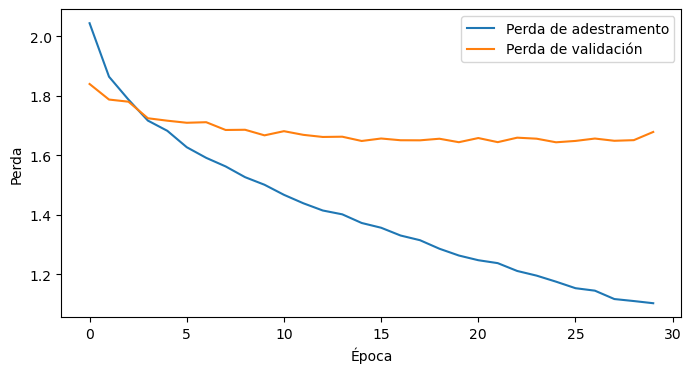

Perda media: 1.659834 Accuracy: 45.0%


**** CONFIGURACIÓN 2: [256] ****


Epoch 1
-------------------------------
perda: 2.311853  [    0/ 7575]
perda: 2.047554  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.821226  [    0/ 7575]
perda: 1.840455  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.573075  [    0/ 7575]
perda: 1.669671  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.711798  [    0/ 7575]
perda: 1.468291  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.772956  [    0/ 7575]
perda: 1.786526  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.437014  [    0/ 7575]
perda: 1.610852  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.743850  [    0/ 7575]
perda: 1.507743  [ 6400/ 7575]
Nonimprovement =  1

Epoch 8
-------------------------------
perda: 1.408546  [    0/ 7575]
perda: 1.477240  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.596887  [    0/ 7575]
perda: 1.3

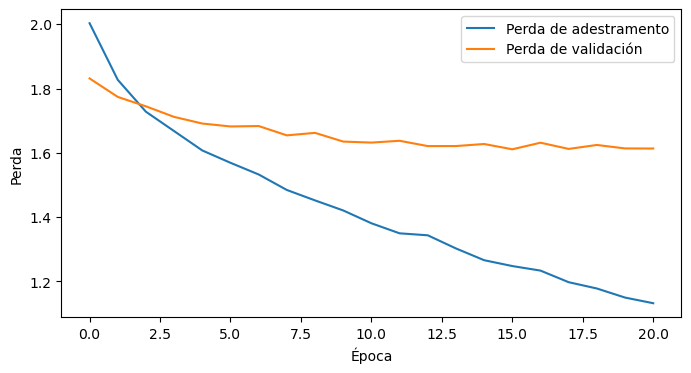

Perda media: 1.635159 Accuracy: 45.9%


**** CONFIGURACIÓN 3: [128, 64] ****


Epoch 1
-------------------------------
perda: 2.342630  [    0/ 7575]
perda: 2.140062  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.171521  [    0/ 7575]
perda: 2.091235  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.204889  [    0/ 7575]
perda: 2.131466  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.088916  [    0/ 7575]
perda: 2.149384  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.107442  [    0/ 7575]
perda: 2.163757  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.110720  [    0/ 7575]
perda: 1.934916  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.965508  [    0/ 7575]
perda: 2.025296  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.968193  [    0/ 7575]
perda: 1.978375  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.852072  [    0/ 7575]
perda: 1.951586  [ 6400/ 7

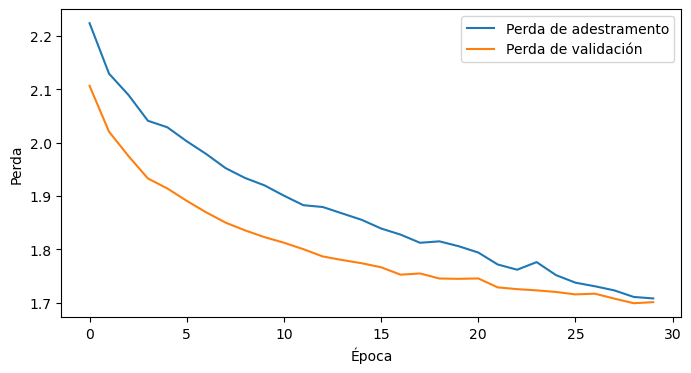

Perda media: 1.723699 Accuracy: 42.3%


**** CONFIGURACIÓN 4: [256, 128] ****


Epoch 1
-------------------------------
perda: 2.349283  [    0/ 7575]
perda: 2.088390  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.105200  [    0/ 7575]
perda: 1.998848  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.740064  [    0/ 7575]
perda: 2.061839  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.972462  [    0/ 7575]
perda: 1.880364  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.055029  [    0/ 7575]
perda: 1.911166  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.940663  [    0/ 7575]
perda: 1.947783  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.952820  [    0/ 7575]
perda: 1.724481  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.831103  [    0/ 7575]
perda: 1.799405  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.826022  [    0/ 7575]
perda: 1.735615  [ 6400/ 

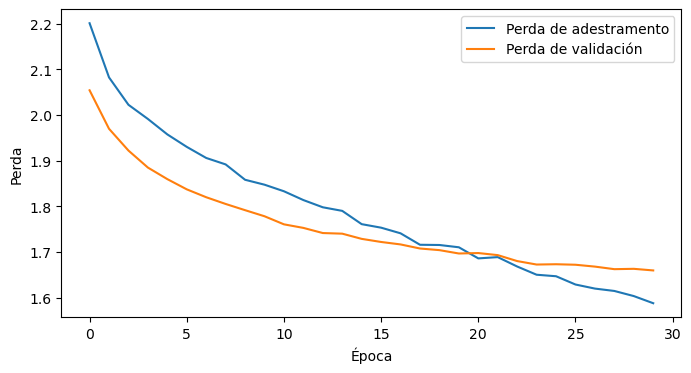

Perda media: 1.678013 Accuracy: 43.9%


**** CONFIGURACIÓN 5: [512, 256, 128] ****


Epoch 1
-------------------------------
perda: 2.338890  [    0/ 7575]
perda: 2.283505  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.238347  [    0/ 7575]
perda: 2.187099  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.276070  [    0/ 7575]
perda: 2.192657  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.274619  [    0/ 7575]
perda: 2.211339  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.192970  [    0/ 7575]
perda: 2.262775  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.155786  [    0/ 7575]
perda: 2.160379  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.086210  [    0/ 7575]
perda: 2.102700  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.073440  [    0/ 7575]
perda: 2.082388  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 2.055445  [    0/ 7575]
perda: 2.062788  [ 6

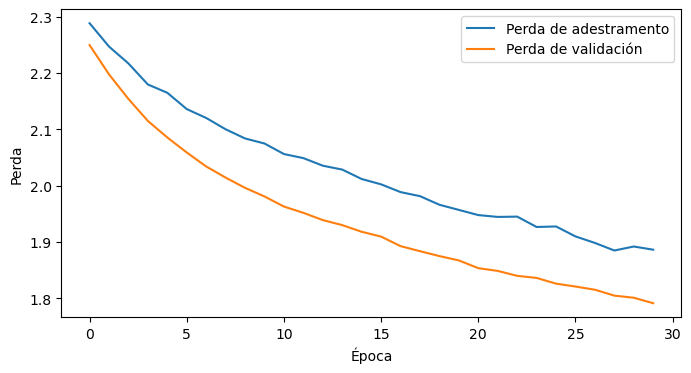

Perda media: 1.823528 Accuracy: 38.0%


**** CONFIGURACIÓN 6: [1024, 512, 256, 128] ****


Epoch 1
-------------------------------
perda: 2.306393  [    0/ 7575]
perda: 2.303654  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.310809  [    0/ 7575]
perda: 2.294935  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.299165  [    0/ 7575]
perda: 2.306947  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.281349  [    0/ 7575]
perda: 2.271506  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.246957  [    0/ 7575]
perda: 2.281194  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.295107  [    0/ 7575]
perda: 2.278919  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.277055  [    0/ 7575]
perda: 2.256600  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.282668  [    0/ 7575]
perda: 2.273154  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 2.237489  [    0/ 7575]
perda: 2.27138

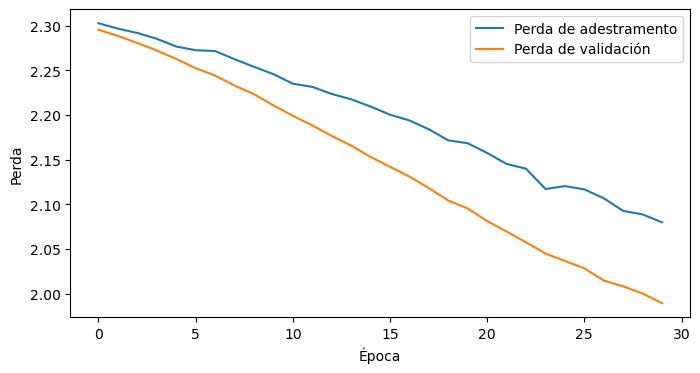

Perda media: 2.023305 Accuracy: 29.2%



In [ ]:
# Posibles combinaciones de capas ocultas para la MLP
hidden_layers_values = [
    [128],
    [256],
    [128, 64],
    [256, 128],
    [512, 256, 128],
    [1024, 512, 256, 128],
]

# Array de resultados
mlp_results = []

# Iterar sobre las configuraciones
for i, hidden_layers in enumerate(hidden_layers_values):
    
    print(f"\n**** CONFIGURACIÓN {i+1}: {hidden_layers} ****\n")

    mlp = MLP(
        input_neurons=128*128*3, # Cambiar en función de la resolución de la imagen
        output_neurons=10, # Las neuronas de salida son 10 porque hay 10 clases
        hidden_layers=hidden_layers
    )

    # Entrenar y evaluar el modelo
    predicted_mlp, true_mlp = train_test(mlp)  

    # Guardar métricas en el array de resultados
    mlp_results.append({
        "hidden_layers": str(hidden_layers),
        "accuracy": accuracy_score(true_mlp, predicted_mlp),
        "recall": recall_score(true_mlp, predicted_mlp, average='macro', zero_division=0),
        "precision": precision_score(true_mlp, predicted_mlp, average='macro', zero_division=0),
        "f1": f1_score(true_mlp, predicted_mlp, zero_division=0, average='macro')
    })

In [32]:
# Mostrar resultados ordenados por accuracy
mlp_df = pd.DataFrame(mlp_results)
display(mlp_df.sort_values(by="accuracy", ascending=False))
mlp_df.shape

,hidden_layers,accuracy,recall,precision,f1
1,[256],0.459108,0.460570,0.452537,0.449552
0,[128],0.450446,0.451885,0.439440,0.440780
3,"[256, 128]",0.439236,0.441778,0.430853,0.425493
2,"[128, 64]",0.422675,0.425554,0.418177,0.405651
4,"[512, 256, 128]",0.379873,0.383562,0.351103,0.346342
5,"[1024, 512, 256, 128]",0.292229,0.296252,0.280333,0.244294


(6, 5)

Tras ejecutar las diferentes configuraciones de capas ocultas se obtienen los resultados que se muestran en la tabla. 

Se observa principalmente como el rendimiento tiende a disminuír a medida que la complejidad del modelo aumenta, siendo las configuraciones más simples (una sola capa oculta) las que mejores resultados proporcionan.

Por otro lado, en configuraciones con más capas el rendimiento empeora obteniéndose un valor de accuracy de 0.292 y de f1-score de 0.244 lo que sugiere un sobreajuste o dificultad para generalizar

Al haber utilizado un patience de 5, es posible que los modelos más complejos no hayan tenido suficiente tiempor para converger antes de que el early stopping detuviera el entrenamiento.


#### Prueba 2 (epochs = 40, patience = 10)

Como con un valor de epochs = 30 y patience = 5 no se observaron grandes mejoras al aumentar la complejidad del modelo (incluso empeoró el rendimiento a medida que aumentaba la complejidad) se ha probado también a incrementar epochs a 40 y patience a 10. El objetivo es proporcionar una mayor margen de entrenamiento para las configuraciones más complejas.


**** CONFIGURACIÓN 1: [128] ****


Epoch 1
-------------------------------
perda: 2.391012  [    0/ 7575]
perda: 1.779943  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.844422  [    0/ 7575]
perda: 1.933227  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.901740  [    0/ 7575]
perda: 1.723748  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.575444  [    0/ 7575]
perda: 1.640383  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.685153  [    0/ 7575]
perda: 1.588969  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.672508  [    0/ 7575]
perda: 1.866786  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.519091  [    0/ 7575]
perda: 1.475040  [ 6400/ 7575]
Nonimprovement =  1

Epoch 8
-------------------------------
perda: 1.627569  [    0/ 7575]
perda: 1.667518  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.594840  [    0/ 7575]
perda: 1.411263  [ 6400/ 7575]

Epoch 10
--------

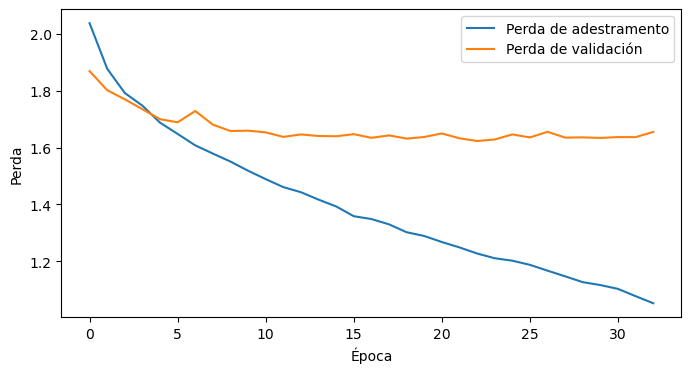

Perda media: 1.663541 Accuracy: 44.2%


**** CONFIGURACIÓN 2: [256] ****


Epoch 1
-------------------------------
perda: 2.323893  [    0/ 7575]
perda: 1.905585  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.913813  [    0/ 7575]
perda: 1.869523  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.824142  [    0/ 7575]
perda: 1.557346  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.484127  [    0/ 7575]
perda: 1.651266  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.575258  [    0/ 7575]
perda: 1.691826  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.421184  [    0/ 7575]
perda: 1.438149  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.455294  [    0/ 7575]
perda: 1.375915  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.451141  [    0/ 7575]
perda: 1.355338  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.337207  [    0/ 7575]
perda: 1.291359  [ 6400/ 7575]

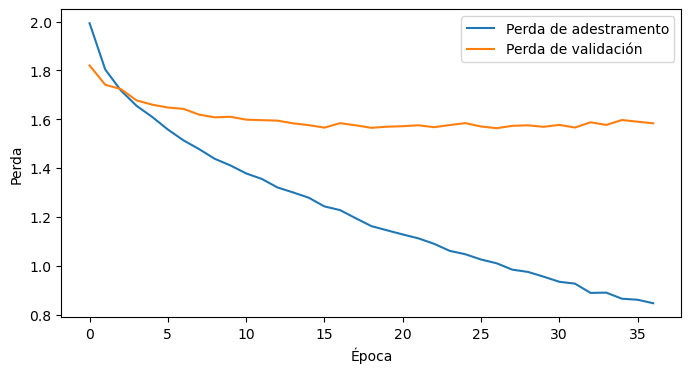

Perda media: 1.633972 Accuracy: 45.6%


**** CONFIGURACIÓN 3: [128, 64] ****


Epoch 1
-------------------------------
perda: 2.321124  [    0/ 7575]
perda: 2.256627  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.179831  [    0/ 7575]
perda: 2.108170  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.129180  [    0/ 7575]
perda: 2.154883  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.004624  [    0/ 7575]
perda: 1.851634  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.942425  [    0/ 7575]
perda: 1.983031  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.945325  [    0/ 7575]
perda: 1.851615  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.097581  [    0/ 7575]
perda: 1.924663  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.022492  [    0/ 7575]
perda: 2.255794  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.953839  [    0/ 7575]
perda: 1.905322  [ 6400/ 7

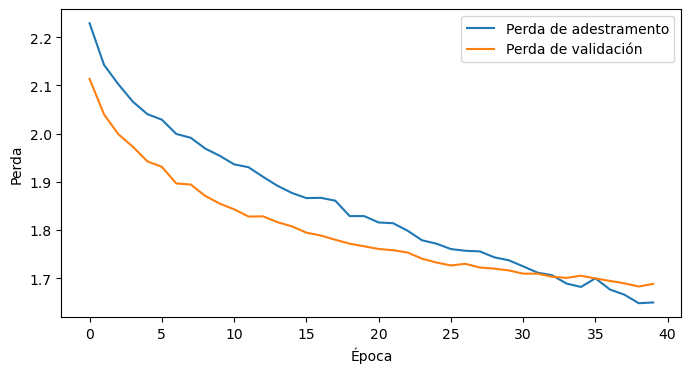

Perda media: 1.710427 Accuracy: 42.0%


**** CONFIGURACIÓN 4: [256, 128] ****


Epoch 1
-------------------------------
perda: 2.337354  [    0/ 7575]
perda: 2.021962  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.133077  [    0/ 7575]
perda: 2.069475  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.195867  [    0/ 7575]
perda: 2.005669  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.896034  [    0/ 7575]
perda: 1.912577  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.066419  [    0/ 7575]
perda: 1.901153  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.899432  [    0/ 7575]
perda: 1.894019  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.978357  [    0/ 7575]
perda: 1.895997  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.873593  [    0/ 7575]
perda: 1.972980  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.884925  [    0/ 7575]
perda: 1.826240  [ 6400/ 

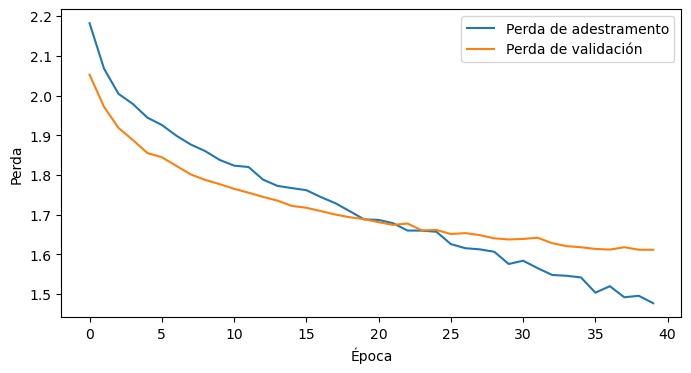

Perda media: 1.646541 Accuracy: 44.6%


**** CONFIGURACIÓN 5: [512, 256, 128] ****


Epoch 1
-------------------------------
perda: 2.331924  [    0/ 7575]
perda: 2.255833  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.254910  [    0/ 7575]
perda: 2.275414  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.218188  [    0/ 7575]
perda: 2.196548  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.139992  [    0/ 7575]
perda: 2.222054  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.119186  [    0/ 7575]
perda: 2.134742  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.163794  [    0/ 7575]
perda: 2.221303  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.070739  [    0/ 7575]
perda: 2.213415  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.008251  [    0/ 7575]
perda: 2.116168  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 2.114027  [    0/ 7575]
perda: 2.221626  [ 6

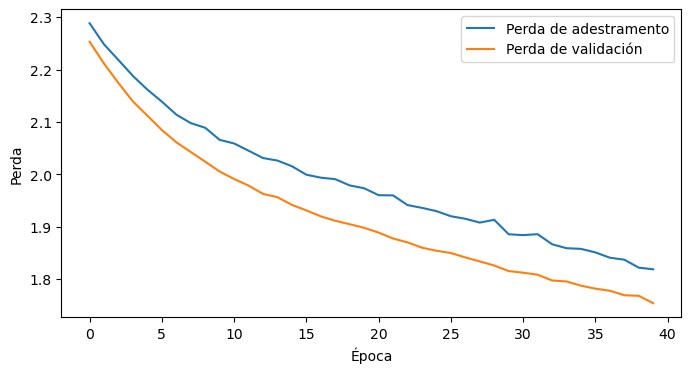

Perda media: 1.787138 Accuracy: 39.6%


**** CONFIGURACIÓN 6: [1024, 512, 256, 128] ****


Epoch 1
-------------------------------
perda: 2.305382  [    0/ 7575]
perda: 2.324445  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.311005  [    0/ 7575]
perda: 2.317251  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.316320  [    0/ 7575]
perda: 2.273643  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.314720  [    0/ 7575]
perda: 2.303413  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.274726  [    0/ 7575]
perda: 2.284058  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.270150  [    0/ 7575]
perda: 2.308711  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.271963  [    0/ 7575]
perda: 2.271489  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.283130  [    0/ 7575]
perda: 2.264620  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 2.270370  [    0/ 7575]
perda: 2.26824

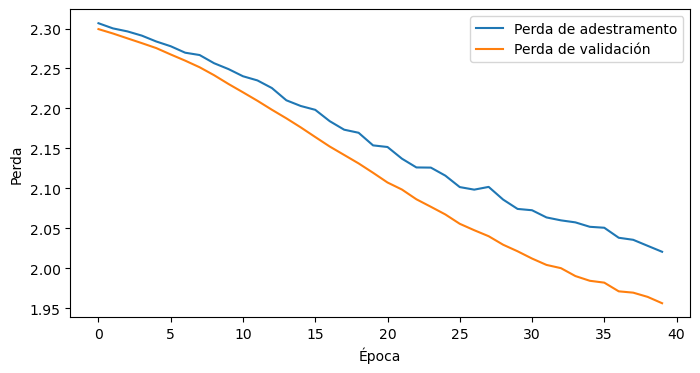

Perda media: 1.976942 Accuracy: 30.1%



In [ ]:
# Posibles combinaciones de capas ocultas para la MLP
hidden_layers_values = [
    [128],
    [256],
    [128, 64],
    [256, 128],
    [512, 256, 128],
    [1024, 512, 256, 128],
]

# Array de resultados
mlp_results_2 = []

# Iterar sobre las configuraciones
for i, hidden_layers in enumerate(hidden_layers_values):
    
    print(f"\n**** CONFIGURACIÓN {i+1}: {hidden_layers} ****\n")

    mlp = MLP(
        input_neurons=128*128*3, # Cambiar en función de la resolución de la imagen
        output_neurons=10, # Las neuronas de salida son 10 porque hay 10 clases
        hidden_layers=hidden_layers
    )

    predicted_mlp, true_mlp = train_test(mlp,epochs=40,patience=10)  

    mlp_results_2.append({
        "hidden_layers": str(hidden_layers),
        "accuracy": accuracy_score(true_mlp, predicted_mlp),
        "recall": recall_score(true_mlp, predicted_mlp, average='macro', zero_division=0),
        "precision": precision_score(true_mlp, predicted_mlp, average='macro', zero_division=0),
        "f1": f1_score(true_mlp, predicted_mlp, zero_division=0, average='macro')
    })

In [11]:
# Mostrar resultados ordenados por accuracy para el entrenamiento 2
mlp_df_2 = pd.DataFrame(mlp_results_2)
display(mlp_df_2.sort_values(by="accuracy", ascending=False))
mlp_df_2.shape

,hidden_layers,accuracy,recall,precision,f1
1,[256],0.455796,0.457519,0.448359,0.449388
3,"[256, 128]",0.445605,0.447768,0.439725,0.434431
0,[128],0.441529,0.443200,0.432520,0.434766
2,"[128, 64]",0.419873,0.422825,0.408779,0.401390
4,"[512, 256, 128]",0.395669,0.399134,0.382419,0.365079
5,"[1024, 512, 256, 128]",0.300892,0.304769,0.254953,0.252016


(6, 5)

Al haber incrementado epochs y patience se obtienen los resultados que se observan en la tabla. 

La intención de este aumento era permitir un mayor margen de entrenamiento a redes más profundas, aun así los resultados se mantienen bastante similares al caso anterior sin ninguna mejora destacable.

Es posible que si siguiesesemos aumentando los valores de epochs y patience no se obtuviese ninguna mejora importante.

### Optimización CNN


**** CONFIGURACIÓN 1: conv_layers=2, first_filters=16, kernel_size=3, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.324027  [    0/ 7575]
perda: 1.863995  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.735354  [    0/ 7575]
perda: 1.579394  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.475237  [    0/ 7575]
perda: 1.630331  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.250489  [    0/ 7575]
perda: 1.474396  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.308355  [    0/ 7575]
perda: 1.284790  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.346011  [    0/ 7575]
perda: 1.159168  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.284824  [    0/ 7575]
perda: 1.393786  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.262961  [    0/ 7575]
perda: 1.053804  [ 6400/ 7575]

Epoch 9
-------------------------------
perda: 1.162959  [    0/

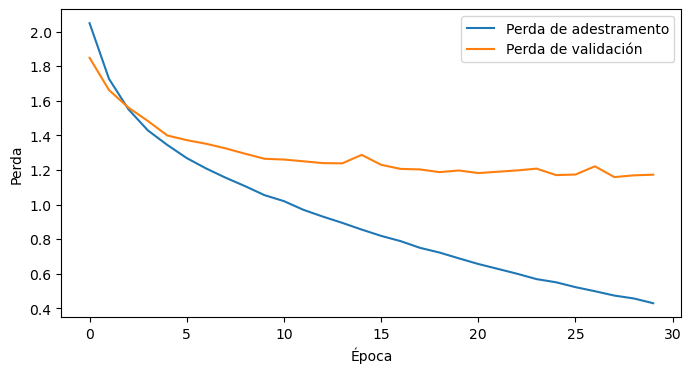

Perda media: 1.221706 Accuracy: 61.0%


**** CONFIGURACIÓN 2: conv_layers=2, first_filters=16, kernel_size=3, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.312698  [    0/ 7575]
perda: 2.197861  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.216804  [    0/ 7575]
perda: 2.113513  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.067366  [    0/ 7575]
perda: 1.969034  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.924409  [    0/ 7575]
perda: 1.778840  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.770544  [    0/ 7575]
perda: 1.587948  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.704727  [    0/ 7575]
perda: 1.646253  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.538462  [    0/ 7575]
perda: 1.466333  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.521905  [    0/ 7575]
perda: 1.257487  [ 6400/ 7575]

Epoch 9
------------

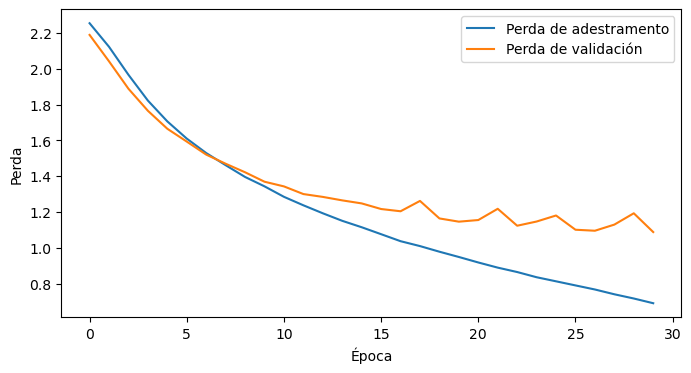

Perda media: 1.135431 Accuracy: 63.7%


**** CONFIGURACIÓN 3: conv_layers=2, first_filters=16, kernel_size=3, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.296430  [    0/ 7575]
perda: 2.258739  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.264117  [    0/ 7575]
perda: 2.236136  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.165817  [    0/ 7575]
perda: 2.142528  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.119172  [    0/ 7575]
perda: 2.082282  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.048409  [    0/ 7575]
perda: 1.956830  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.866039  [    0/ 7575]
perda: 1.819589  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.734466  [    0/ 7575]
perda: 1.790736  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.966359  [    0/ 7575]
perda: 1.562993  [ 6400/ 7575]

Epoch 9
----------------

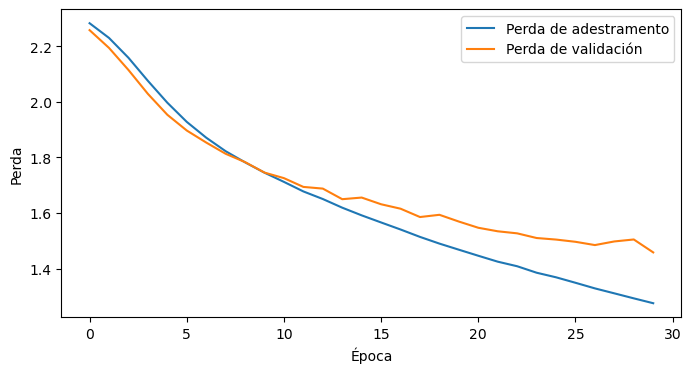

Perda media: 1.462120 Accuracy: 51.9%


**** CONFIGURACIÓN 4: conv_layers=2, first_filters=16, kernel_size=3, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.311156  [    0/ 7575]
perda: 2.286598  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.295300  [    0/ 7575]
perda: 2.289691  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.283178  [    0/ 7575]
perda: 2.275011  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.263249  [    0/ 7575]
perda: 2.247783  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.244277  [    0/ 7575]
perda: 2.238459  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.240212  [    0/ 7575]
perda: 2.176730  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.199414  [    0/ 7575]
perda: 2.163877  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.131991  [    0/ 7575]
perda: 2.169997  [ 6400/ 7575]

Epoch 9
-----------

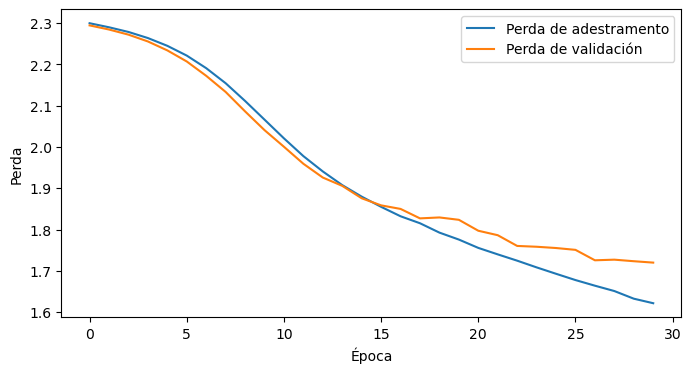

Perda media: 1.711366 Accuracy: 41.6%


**** CONFIGURACIÓN 5: conv_layers=2, first_filters=16, kernel_size=5, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.323997  [    0/ 7575]
perda: 1.833842  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.805268  [    0/ 7575]
perda: 1.681551  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.699753  [    0/ 7575]
perda: 1.561683  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.552379  [    0/ 7575]
perda: 1.401847  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.614396  [    0/ 7575]
perda: 1.245502  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.098868  [    0/ 7575]
perda: 1.341806  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.201529  [    0/ 7575]
perda: 1.265114  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.090507  [    0/ 7575]
perda: 1.259920  [ 6400/ 7575]

Epoch 9
-----------------

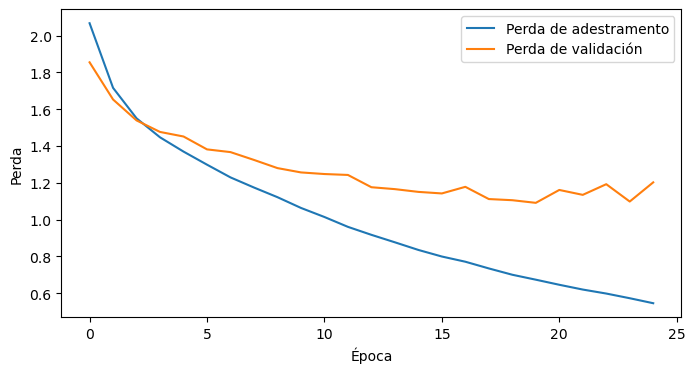

Perda media: 1.125205 Accuracy: 64.4%


**** CONFIGURACIÓN 6: conv_layers=2, first_filters=16, kernel_size=5, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.307616  [    0/ 7575]
perda: 2.210581  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.194942  [    0/ 7575]
perda: 2.078553  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.059578  [    0/ 7575]
perda: 1.982253  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.937629  [    0/ 7575]
perda: 1.881611  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.700424  [    0/ 7575]
perda: 1.684647  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.910159  [    0/ 7575]
perda: 1.735854  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.648085  [    0/ 7575]
perda: 1.468598  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.691613  [    0/ 7575]
perda: 1.328315  [ 6400/ 7575]

Epoch 9
------------

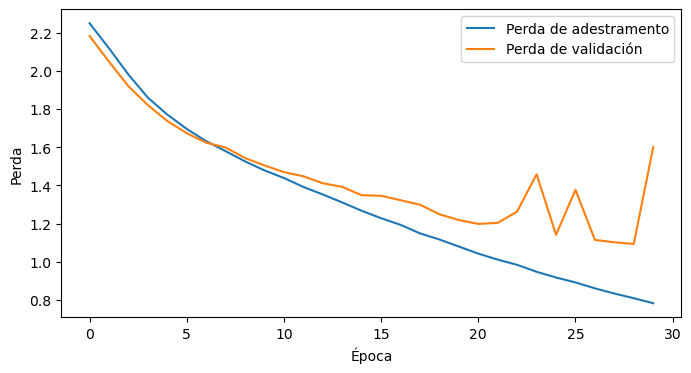

Perda media: 1.146716 Accuracy: 62.5%


**** CONFIGURACIÓN 7: conv_layers=2, first_filters=16, kernel_size=5, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.298710  [    0/ 7575]
perda: 2.216885  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.203586  [    0/ 7575]
perda: 2.076379  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.120950  [    0/ 7575]
perda: 1.962213  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.961409  [    0/ 7575]
perda: 1.951617  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.867890  [    0/ 7575]
perda: 1.871015  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.991249  [    0/ 7575]
perda: 1.860637  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.883817  [    0/ 7575]
perda: 1.729538  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.695173  [    0/ 7575]
perda: 1.805076  [ 6400/ 7575]

Epoch 9
----------------

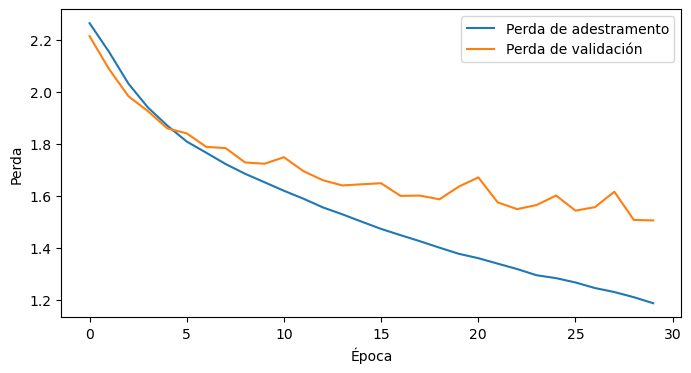

Perda media: 1.537023 Accuracy: 49.0%


**** CONFIGURACIÓN 8: conv_layers=2, first_filters=16, kernel_size=5, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.289715  [    0/ 7575]
perda: 2.291650  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.288548  [    0/ 7575]
perda: 2.282098  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.277575  [    0/ 7575]
perda: 2.261435  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.251405  [    0/ 7575]
perda: 2.248054  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.161752  [    0/ 7575]
perda: 2.155907  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.183878  [    0/ 7575]
perda: 2.141289  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.130405  [    0/ 7575]
perda: 2.157058  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.116701  [    0/ 7575]
perda: 2.011909  [ 6400/ 7575]

Epoch 9
-----------

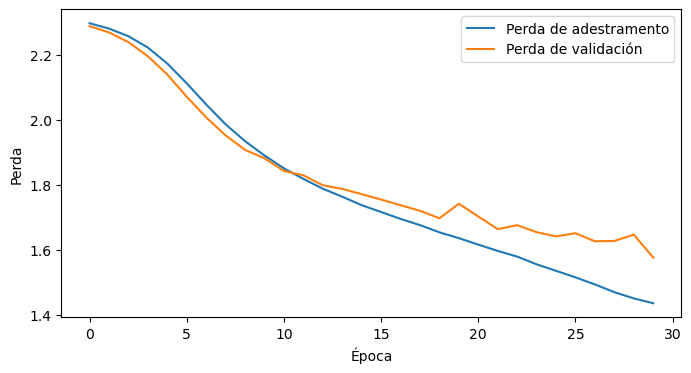

Perda media: 1.584918 Accuracy: 46.6%


**** CONFIGURACIÓN 9: conv_layers=2, first_filters=32, kernel_size=3, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.359286  [    0/ 7575]
perda: 1.831277  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.719150  [    0/ 7575]
perda: 1.311293  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.326661  [    0/ 7575]
perda: 1.371054  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.346152  [    0/ 7575]
perda: 1.210357  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.213541  [    0/ 7575]
perda: 1.291847  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.290944  [    0/ 7575]
perda: 1.105932  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.036974  [    0/ 7575]
perda: 1.067827  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.046069  [    0/ 7575]
perda: 0.947440  [ 6400/ 7575]
Nonimprovement =  1

Epoch

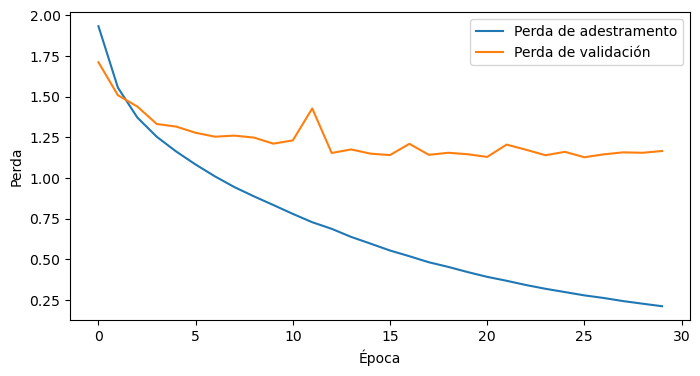

Perda media: 1.187621 Accuracy: 62.6%


**** CONFIGURACIÓN 10: conv_layers=2, first_filters=32, kernel_size=3, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.291518  [    0/ 7575]
perda: 2.067690  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.094926  [    0/ 7575]
perda: 1.835544  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.758479  [    0/ 7575]
perda: 1.570030  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.565141  [    0/ 7575]
perda: 1.577311  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.402020  [    0/ 7575]
perda: 1.495382  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.512064  [    0/ 7575]
perda: 1.229519  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.274633  [    0/ 7575]
perda: 1.313756  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.134907  [    0/ 7575]
perda: 1.277288  [ 6400/ 7575]

Epoch 9
-----------

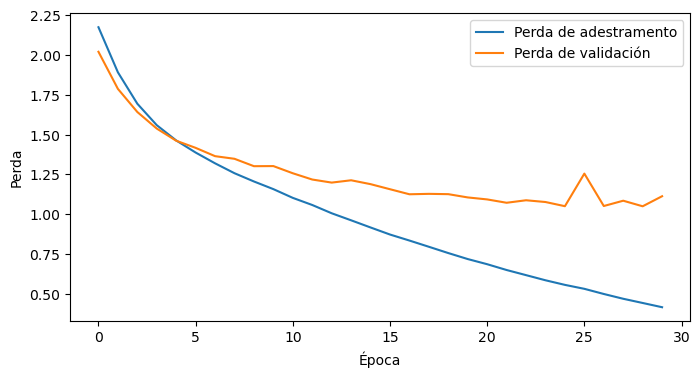

Perda media: 1.128913 Accuracy: 64.0%


**** CONFIGURACIÓN 11: conv_layers=2, first_filters=32, kernel_size=3, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.293207  [    0/ 7575]
perda: 2.231810  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.191177  [    0/ 7575]
perda: 2.133907  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.131455  [    0/ 7575]
perda: 2.066341  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.982773  [    0/ 7575]
perda: 1.824831  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.727131  [    0/ 7575]
perda: 2.008841  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.815566  [    0/ 7575]
perda: 1.814708  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.795230  [    0/ 7575]
perda: 1.848119  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.761099  [    0/ 7575]
perda: 1.532483  [ 6400/ 7575]

Epoch 9
---------------

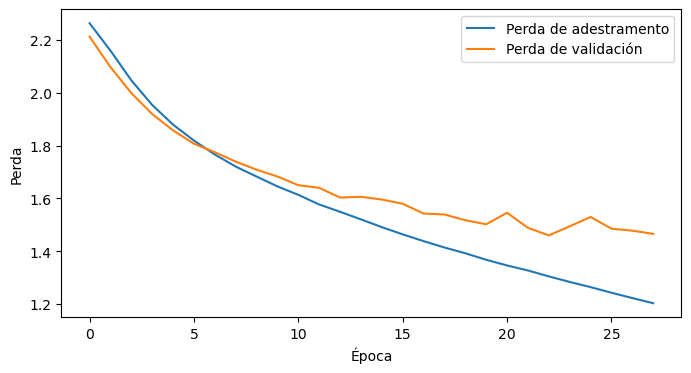

Perda media: 1.480032 Accuracy: 51.4%


**** CONFIGURACIÓN 12: conv_layers=2, first_filters=32, kernel_size=3, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.313967  [    0/ 7575]
perda: 2.288787  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.288366  [    0/ 7575]
perda: 2.271619  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.273998  [    0/ 7575]
perda: 2.236309  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.219326  [    0/ 7575]
perda: 2.189670  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.205261  [    0/ 7575]
perda: 2.127345  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.150219  [    0/ 7575]
perda: 2.119082  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.135069  [    0/ 7575]
perda: 2.080226  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.070662  [    0/ 7575]
perda: 2.122745  [ 6400/ 7575]

Epoch 9
----------

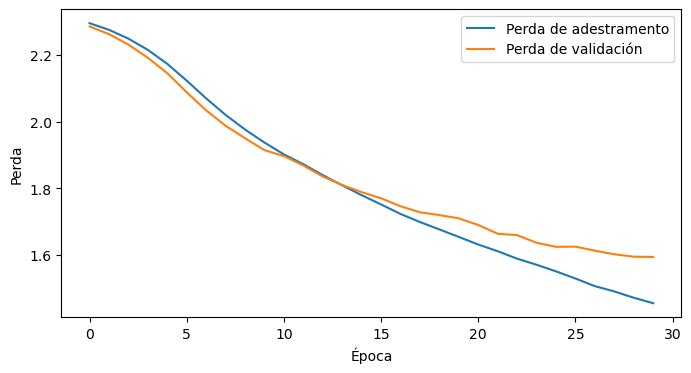

Perda media: 1.618355 Accuracy: 45.0%


**** CONFIGURACIÓN 13: conv_layers=2, first_filters=32, kernel_size=5, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.329605  [    0/ 7575]
perda: 1.719362  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.879221  [    0/ 7575]
perda: 1.820042  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.385893  [    0/ 7575]
perda: 1.153153  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.250245  [    0/ 7575]
perda: 1.097975  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.220781  [    0/ 7575]
perda: 1.088781  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.004136  [    0/ 7575]
perda: 1.185510  [ 6400/ 7575]
Nonimprovement =  1

Epoch 7
-------------------------------
perda: 0.973724  [    0/ 7575]
perda: 1.057133  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.015129  [    0/ 7575]
perda: 1.006899  [ 6400/ 7575]

Epoc

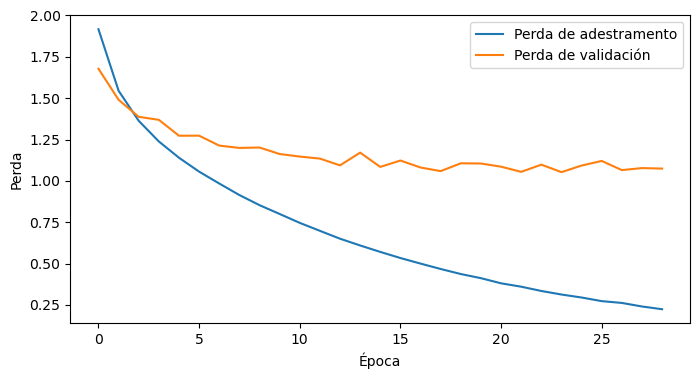

Perda media: 1.117839 Accuracy: 65.3%


**** CONFIGURACIÓN 14: conv_layers=2, first_filters=32, kernel_size=5, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.295208  [    0/ 7575]
perda: 2.093334  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.991577  [    0/ 7575]
perda: 1.815021  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.814837  [    0/ 7575]
perda: 1.620224  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.552799  [    0/ 7575]
perda: 1.343159  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.551139  [    0/ 7575]
perda: 1.518716  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.378178  [    0/ 7575]
perda: 1.686576  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.451085  [    0/ 7575]
perda: 1.539655  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.297579  [    0/ 7575]
perda: 1.226024  [ 6400/ 7575]

Epoch 9
-----------

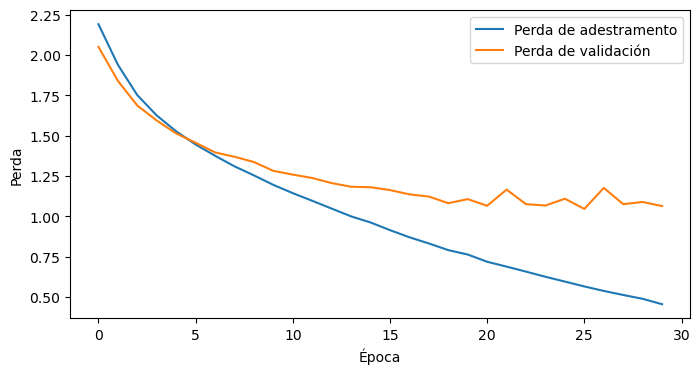

Perda media: 1.088158 Accuracy: 65.5%


**** CONFIGURACIÓN 15: conv_layers=2, first_filters=32, kernel_size=5, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.316329  [    0/ 7575]
perda: 2.215155  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.224587  [    0/ 7575]
perda: 2.108476  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.067661  [    0/ 7575]
perda: 2.074648  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.884836  [    0/ 7575]
perda: 2.030571  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.789020  [    0/ 7575]
perda: 1.707384  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.592408  [    0/ 7575]
perda: 1.604870  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.806206  [    0/ 7575]
perda: 1.781164  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.544054  [    0/ 7575]
perda: 1.634581  [ 6400/ 7575]

Epoch 9
---------------

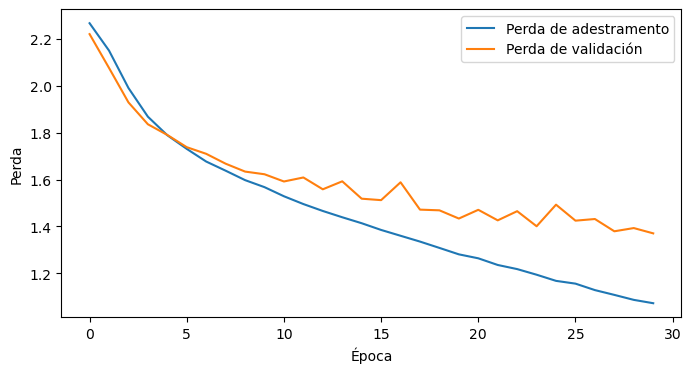

Perda media: 1.415757 Accuracy: 53.9%


**** CONFIGURACIÓN 16: conv_layers=2, first_filters=32, kernel_size=5, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.302357  [    0/ 7575]
perda: 2.276671  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.276539  [    0/ 7575]
perda: 2.241444  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.202608  [    0/ 7575]
perda: 2.189675  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.116256  [    0/ 7575]
perda: 2.111538  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.133918  [    0/ 7575]
perda: 2.139659  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.041757  [    0/ 7575]
perda: 2.009271  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.930774  [    0/ 7575]
perda: 1.907202  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.883431  [    0/ 7575]
perda: 1.708031  [ 6400/ 7575]

Epoch 9
----------

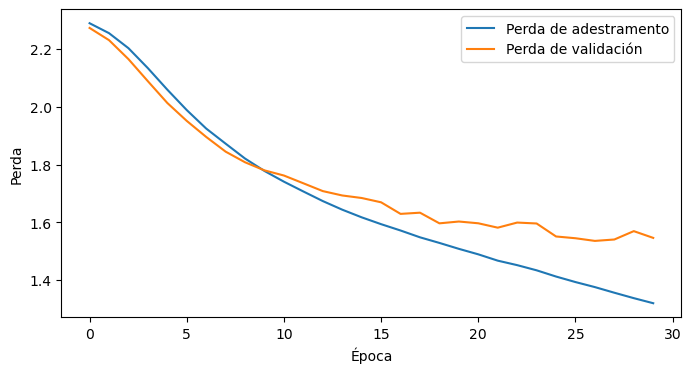

Perda media: 1.541923 Accuracy: 49.2%


**** CONFIGURACIÓN 17: conv_layers=3, first_filters=16, kernel_size=3, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.306889  [    0/ 7575]
perda: 2.061088  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.973178  [    0/ 7575]
perda: 1.661788  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.700665  [    0/ 7575]
perda: 1.608000  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.730796  [    0/ 7575]
perda: 1.521398  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.538211  [    0/ 7575]
perda: 1.513562  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.399357  [    0/ 7575]
perda: 1.640054  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.477752  [    0/ 7575]
perda: 1.365744  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.205446  [    0/ 7575]
perda: 1.356113  [ 6400/ 7575]

Epoch 9
----------------

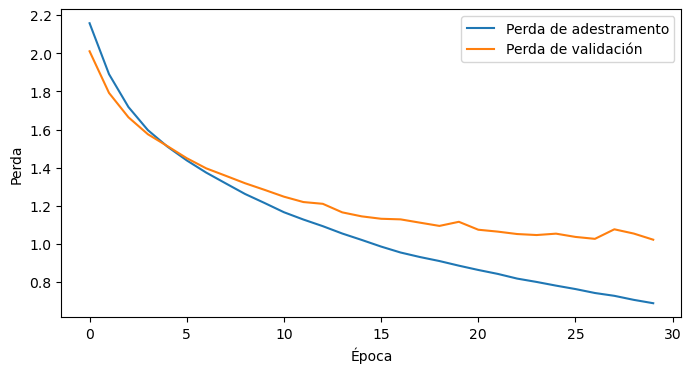

Perda media: 1.076877 Accuracy: 65.2%


**** CONFIGURACIÓN 18: conv_layers=3, first_filters=16, kernel_size=3, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.294762  [    0/ 7575]
perda: 2.238137  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.260866  [    0/ 7575]
perda: 2.193238  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.113985  [    0/ 7575]
perda: 2.040359  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.026561  [    0/ 7575]
perda: 2.040453  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.919969  [    0/ 7575]
perda: 1.818059  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.886451  [    0/ 7575]
perda: 1.947625  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.830118  [    0/ 7575]
perda: 1.893333  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.664281  [    0/ 7575]
perda: 1.600507  [ 6400/ 7575]

Epoch 9
-----------

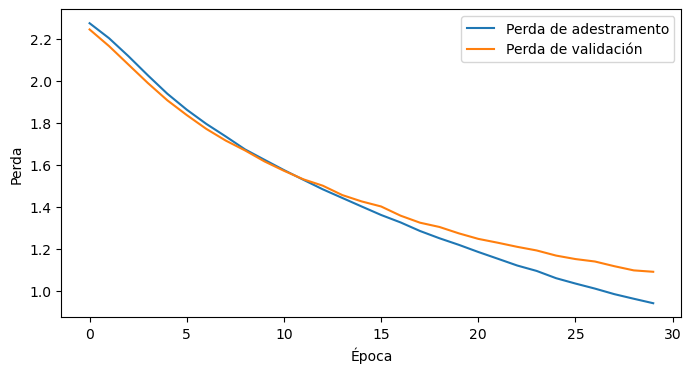

Perda media: 1.122778 Accuracy: 63.5%


**** CONFIGURACIÓN 19: conv_layers=3, first_filters=16, kernel_size=3, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.315492  [    0/ 7575]
perda: 2.308048  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.304090  [    0/ 7575]
perda: 2.300790  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.299299  [    0/ 7575]
perda: 2.294384  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.286045  [    0/ 7575]
perda: 2.290557  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.289506  [    0/ 7575]
perda: 2.282634  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.274070  [    0/ 7575]
perda: 2.277198  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.263817  [    0/ 7575]
perda: 2.251354  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.256948  [    0/ 7575]
perda: 2.246381  [ 6400/ 7575]

Epoch 9
---------------

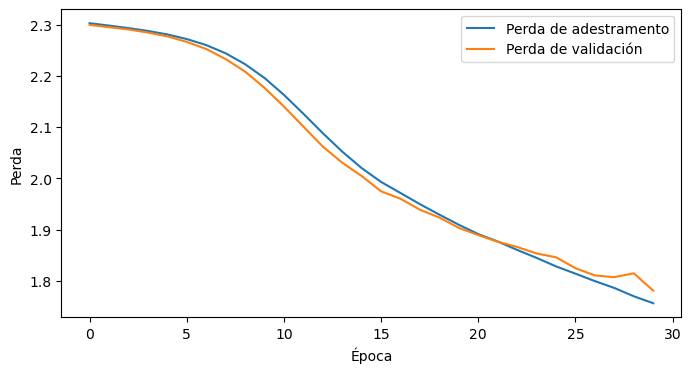

Perda media: 1.813484 Accuracy: 38.3%


**** CONFIGURACIÓN 20: conv_layers=3, first_filters=16, kernel_size=3, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.308839  [    0/ 7575]
perda: 2.307330  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.301354  [    0/ 7575]
perda: 2.293609  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.305321  [    0/ 7575]
perda: 2.289078  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.295501  [    0/ 7575]
perda: 2.302896  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.292243  [    0/ 7575]
perda: 2.298100  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.307612  [    0/ 7575]
perda: 2.290368  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.288663  [    0/ 7575]
perda: 2.290172  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.296129  [    0/ 7575]
perda: 2.295444  [ 6400/ 7575]

Epoch 9
----------

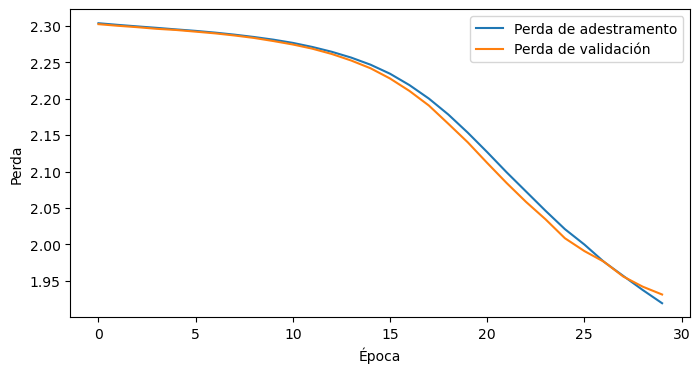

Perda media: 1.961336 Accuracy: 32.9%


**** CONFIGURACIÓN 21: conv_layers=3, first_filters=16, kernel_size=5, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.379226  [    0/ 7575]
perda: 2.147286  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.000160  [    0/ 7575]
perda: 1.832554  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.812813  [    0/ 7575]
perda: 1.759645  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.730349  [    0/ 7575]
perda: 1.629437  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.626248  [    0/ 7575]
perda: 1.783776  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.711330  [    0/ 7575]
perda: 1.407715  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.385491  [    0/ 7575]
perda: 1.496370  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.260699  [    0/ 7575]
perda: 1.534239  [ 6400/ 7575]

Epoch 9
----------------

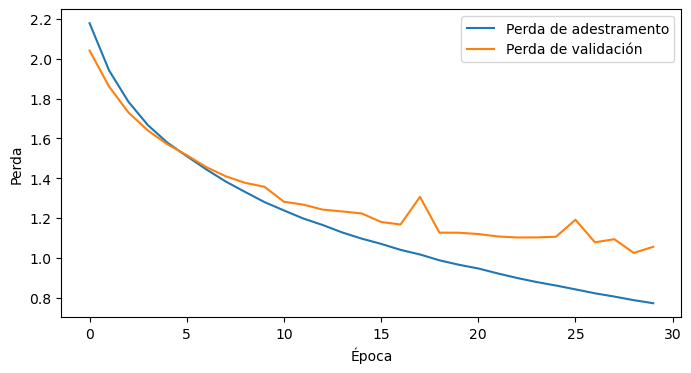

Perda media: 1.075446 Accuracy: 65.1%


**** CONFIGURACIÓN 22: conv_layers=3, first_filters=16, kernel_size=5, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.306993  [    0/ 7575]
perda: 2.290541  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.270651  [    0/ 7575]
perda: 2.237108  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.211020  [    0/ 7575]
perda: 2.167877  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.162181  [    0/ 7575]
perda: 1.979145  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.026062  [    0/ 7575]
perda: 2.022144  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.981370  [    0/ 7575]
perda: 1.944457  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.976383  [    0/ 7575]
perda: 1.851086  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.981982  [    0/ 7575]
perda: 1.861329  [ 6400/ 7575]

Epoch 9
-----------

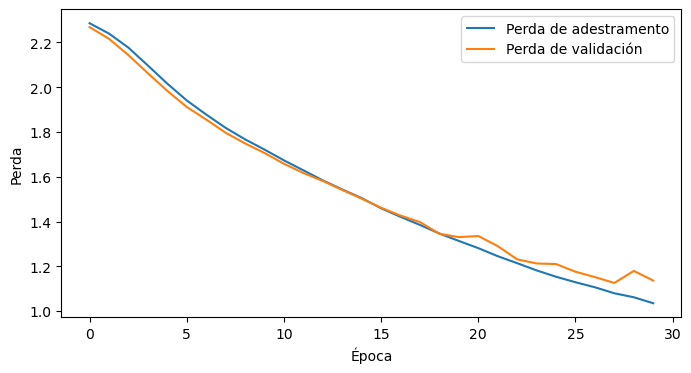

Perda media: 1.182778 Accuracy: 62.7%


**** CONFIGURACIÓN 23: conv_layers=3, first_filters=16, kernel_size=5, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.305018  [    0/ 7575]
perda: 2.297650  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.302071  [    0/ 7575]
perda: 2.300858  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.278863  [    0/ 7575]
perda: 2.286658  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.298001  [    0/ 7575]
perda: 2.266789  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.253441  [    0/ 7575]
perda: 2.256887  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.260089  [    0/ 7575]
perda: 2.141011  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.198787  [    0/ 7575]
perda: 2.150083  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.041321  [    0/ 7575]
perda: 2.141230  [ 6400/ 7575]

Epoch 9
---------------

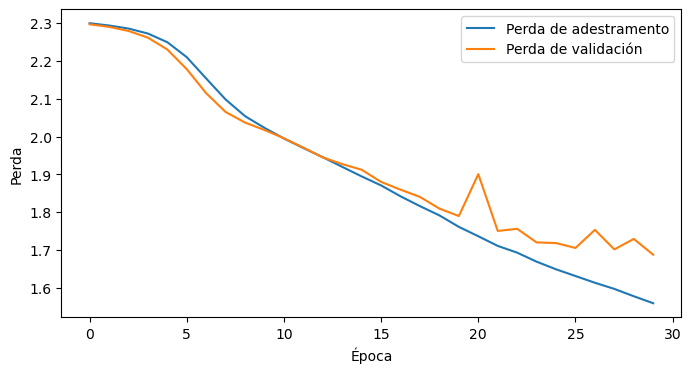

Perda media: 1.712599 Accuracy: 42.2%


**** CONFIGURACIÓN 24: conv_layers=3, first_filters=16, kernel_size=5, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.295893  [    0/ 7575]
perda: 2.296248  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.299767  [    0/ 7575]
perda: 2.306865  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.294690  [    0/ 7575]
perda: 2.300910  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.293374  [    0/ 7575]
perda: 2.288674  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.301254  [    0/ 7575]
perda: 2.298465  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.292044  [    0/ 7575]
perda: 2.301846  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.294883  [    0/ 7575]
perda: 2.289922  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.294668  [    0/ 7575]
perda: 2.288294  [ 6400/ 7575]

Epoch 9
----------

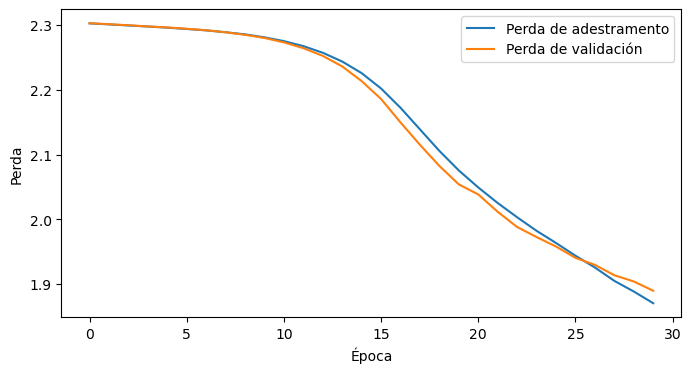

Perda media: 1.925860 Accuracy: 33.3%


**** CONFIGURACIÓN 25: conv_layers=3, first_filters=32, kernel_size=3, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.332977  [    0/ 7575]
perda: 1.809631  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.775510  [    0/ 7575]
perda: 1.381905  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.514806  [    0/ 7575]
perda: 1.476181  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.478206  [    0/ 7575]
perda: 1.269799  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.256342  [    0/ 7575]
perda: 1.191227  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.320469  [    0/ 7575]
perda: 1.136538  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 0.920659  [    0/ 7575]
perda: 1.041651  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.119633  [    0/ 7575]
perda: 1.067999  [ 6400/ 7575]

Epoch 9
----------------

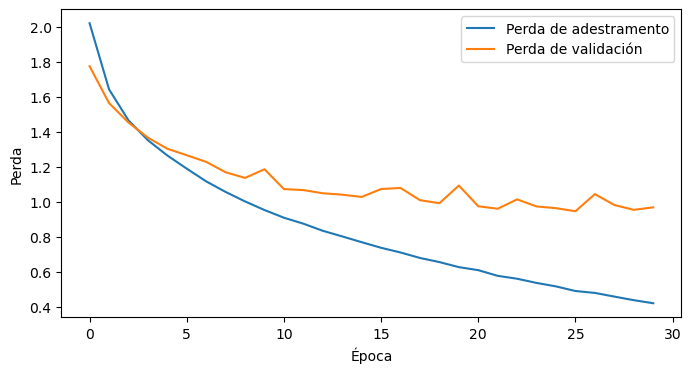

Perda media: 0.995707 Accuracy: 68.2%


**** CONFIGURACIÓN 26: conv_layers=3, first_filters=32, kernel_size=3, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.304605  [    0/ 7575]
perda: 2.229218  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.162005  [    0/ 7575]
perda: 2.085729  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.044295  [    0/ 7575]
perda: 1.757593  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.845579  [    0/ 7575]
perda: 1.748471  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.681204  [    0/ 7575]
perda: 1.686437  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.755534  [    0/ 7575]
perda: 1.461100  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.507489  [    0/ 7575]
perda: 1.538384  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.275776  [    0/ 7575]
perda: 1.503121  [ 6400/ 7575]

Epoch 9
-----------

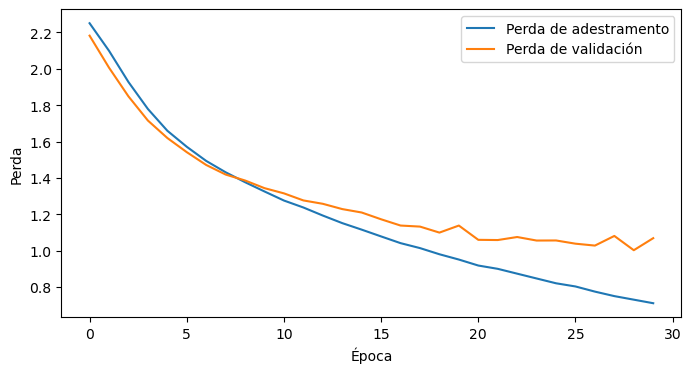

Perda media: 1.034489 Accuracy: 66.7%


**** CONFIGURACIÓN 27: conv_layers=3, first_filters=32, kernel_size=3, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.306760  [    0/ 7575]
perda: 2.277734  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.281770  [    0/ 7575]
perda: 2.272791  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.272551  [    0/ 7575]
perda: 2.240634  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.239526  [    0/ 7575]
perda: 2.251873  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.203898  [    0/ 7575]
perda: 2.221836  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.249901  [    0/ 7575]
perda: 2.181952  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.158272  [    0/ 7575]
perda: 2.172152  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.086077  [    0/ 7575]
perda: 2.129208  [ 6400/ 7575]

Epoch 9
---------------

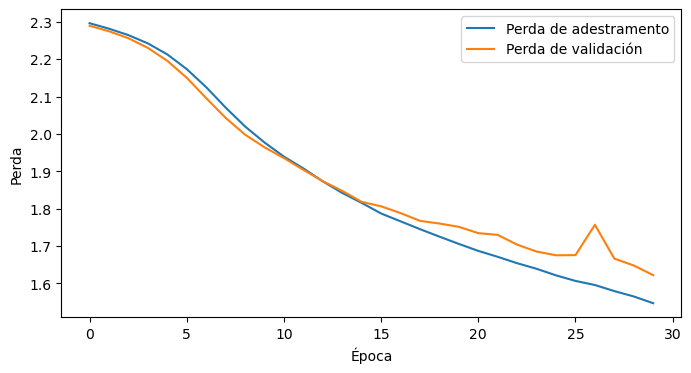

Perda media: 1.651444 Accuracy: 44.0%


**** CONFIGURACIÓN 28: conv_layers=3, first_filters=32, kernel_size=3, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.311275  [    0/ 7575]
perda: 2.294242  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.294846  [    0/ 7575]
perda: 2.298929  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.295163  [    0/ 7575]
perda: 2.295596  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.289227  [    0/ 7575]
perda: 2.302166  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.291234  [    0/ 7575]
perda: 2.284100  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.285294  [    0/ 7575]
perda: 2.285474  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.289907  [    0/ 7575]
perda: 2.282015  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.279788  [    0/ 7575]
perda: 2.277916  [ 6400/ 7575]

Epoch 9
----------

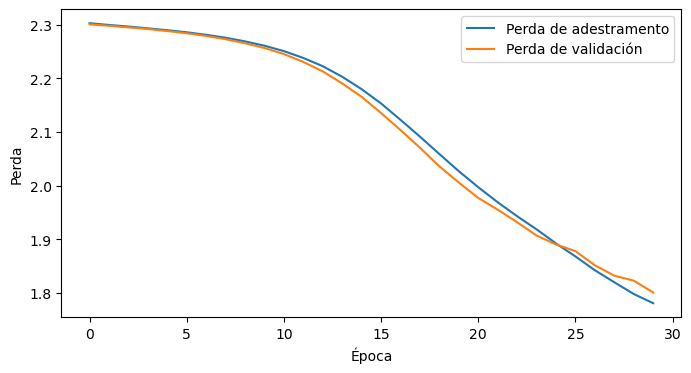

Perda media: 1.817192 Accuracy: 38.1%


**** CONFIGURACIÓN 29: conv_layers=3, first_filters=32, kernel_size=5, batch_norm=True, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.347118  [    0/ 7575]
perda: 1.983444  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 1.777875  [    0/ 7575]
perda: 1.714383  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 1.845075  [    0/ 7575]
perda: 1.495163  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.566276  [    0/ 7575]
perda: 1.523742  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.426562  [    0/ 7575]
perda: 1.380490  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.368934  [    0/ 7575]
perda: 1.190051  [ 6400/ 7575]
Nonimprovement =  1

Epoch 7
-------------------------------
perda: 1.160572  [    0/ 7575]
perda: 1.221965  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 0.991645  [    0/ 7575]
perda: 1.055361  [ 6400/ 7575]

Epoc

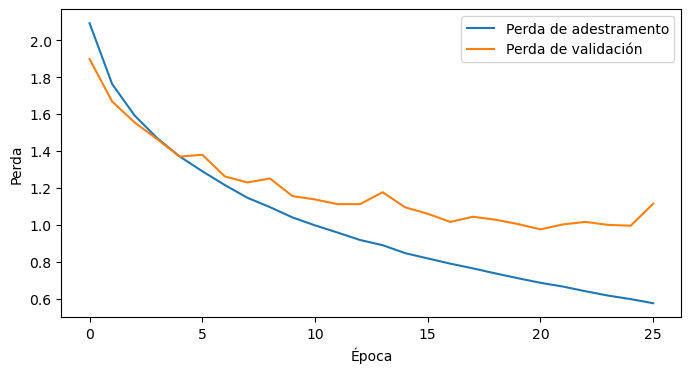

Perda media: 1.042240 Accuracy: 66.9%


**** CONFIGURACIÓN 30: conv_layers=3, first_filters=32, kernel_size=5, batch_norm=True, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.336845  [    0/ 7575]
perda: 2.230442  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.163078  [    0/ 7575]
perda: 2.215986  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.045851  [    0/ 7575]
perda: 1.945845  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 1.953174  [    0/ 7575]
perda: 1.823878  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 1.824340  [    0/ 7575]
perda: 1.901214  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 1.804824  [    0/ 7575]
perda: 1.607493  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 1.744548  [    0/ 7575]
perda: 1.720917  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 1.456435  [    0/ 7575]
perda: 1.587542  [ 6400/ 7575]

Epoch 9
-----------

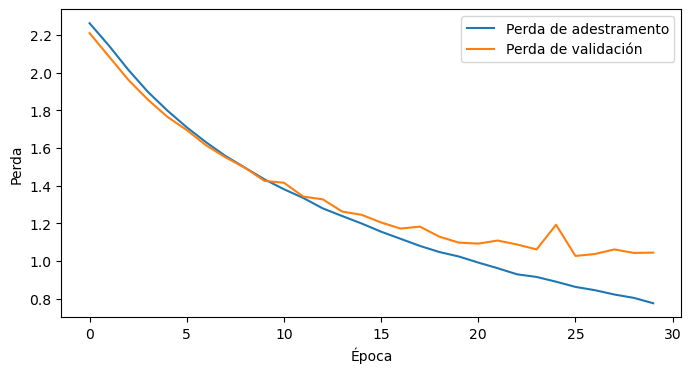

Perda media: 1.078918 Accuracy: 64.8%


**** CONFIGURACIÓN 31: conv_layers=3, first_filters=32, kernel_size=5, batch_norm=False, mlp_layers=[128] ****


Epoch 1
-------------------------------
perda: 2.307690  [    0/ 7575]
perda: 2.303032  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.310232  [    0/ 7575]
perda: 2.287800  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.279274  [    0/ 7575]
perda: 2.270663  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.268362  [    0/ 7575]
perda: 2.265597  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.237939  [    0/ 7575]
perda: 2.191459  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.253706  [    0/ 7575]
perda: 2.217270  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.195244  [    0/ 7575]
perda: 2.098403  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.125588  [    0/ 7575]
perda: 2.059082  [ 6400/ 7575]

Epoch 9
---------------

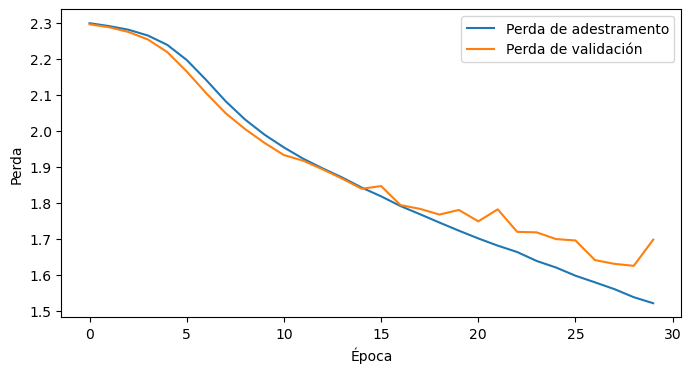

Perda media: 1.641415 Accuracy: 44.3%


**** CONFIGURACIÓN 32: conv_layers=3, first_filters=32, kernel_size=5, batch_norm=False, mlp_layers=[256, 128] ****


Epoch 1
-------------------------------
perda: 2.309713  [    0/ 7575]
perda: 2.293027  [ 6400/ 7575]

Epoch 2
-------------------------------
perda: 2.303258  [    0/ 7575]
perda: 2.298167  [ 6400/ 7575]

Epoch 3
-------------------------------
perda: 2.299209  [    0/ 7575]
perda: 2.295400  [ 6400/ 7575]

Epoch 4
-------------------------------
perda: 2.294939  [    0/ 7575]
perda: 2.295906  [ 6400/ 7575]

Epoch 5
-------------------------------
perda: 2.294815  [    0/ 7575]
perda: 2.293823  [ 6400/ 7575]

Epoch 6
-------------------------------
perda: 2.289636  [    0/ 7575]
perda: 2.291767  [ 6400/ 7575]

Epoch 7
-------------------------------
perda: 2.276374  [    0/ 7575]
perda: 2.268741  [ 6400/ 7575]

Epoch 8
-------------------------------
perda: 2.289364  [    0/ 7575]
perda: 2.262915  [ 6400/ 7575]

Epoch 9
----------

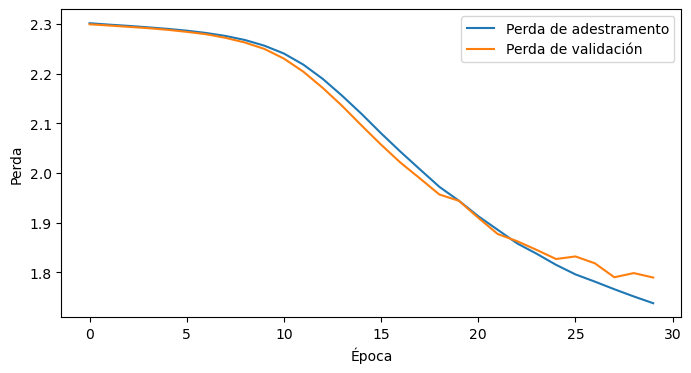

Perda media: 1.807351 Accuracy: 37.8%



In [33]:
# Parámetros a probar
conv_layers_values = [2, 3]
first_conv_filters_values = [16, 32]
conv_kernel_size_values = [3, 5]
batch_norm_values = [True, False]
hidden_mlp_layers_values = [[128], [256, 128]]

# Array de resultados
cnn_results = []

# Obtener todas las combinaciones de parámetros
combinaciones = list(itertools.product(
    conv_layers_values,
    first_conv_filters_values,
    conv_kernel_size_values,
    batch_norm_values,
    hidden_mlp_layers_values
))

# Bucle para probar combinaciones de parámetros
for i, (conv_layers, first_filters, kernel_size, batch_norm, mlp_layers) in enumerate(combinaciones):
    
    print(f"\n**** CONFIGURACIÓN {i+1}: conv_layers={conv_layers}, first_filters={first_filters}, kernel_size={kernel_size}, batch_norm={batch_norm}, mlp_layers={mlp_layers} ****\n")

    cnn = CNN(
        input_channels=3, # Cambiar según el número de canales de la imagen (RGB=3)
        conv_layers=conv_layers,
        first_conv_filters=first_filters,
        conv_kernel_size=kernel_size,
        batch_norm=batch_norm,
        hidden_mlp_layers=mlp_layers,
        output_neurons=10, # Cambiar según el número de clases
        input_size=[128, 128] # Cambiar en función del tamaño de la imagen de entrada
    )

    predicted_cnn, true_cnn = train_test(cnn)

    cnn_results.append({
        'conv_layers': conv_layers,
        'first_filters': first_filters,
        'kernel_size': kernel_size,
        'batch_norm': batch_norm,
        'mlp_layers': str(mlp_layers),
        "accuracy": accuracy_score(true_cnn, predicted_cnn),
        "recall": recall_score(true_cnn, predicted_cnn, average='macro', zero_division=0),
        "precision": precision_score(true_cnn, predicted_cnn, average='macro', zero_division=0),
        "f1": f1_score(true_cnn, predicted_cnn, zero_division=0, average='macro')

    })

In [ ]:
# Mostrar resultados ordenados por accuracy
cnn_df = pd.DataFrame(cnn_results)
display(cnn_df.sort_values(by="accuracy", ascending=False))
#comentario solo para que funcione el push

,conv_layers,first_filters,kernel_size,batch_norm,mlp_layers,accuracy,recall,precision,f1
24,3,32,3,True,[128],0.682038,0.682944,0.683237,0.680974
28,3,32,5,True,[128],0.669299,0.669560,0.672453,0.666967
25,3,32,3,True,"[256, 128]",0.666752,0.666739,0.669703,0.663454
13,2,32,5,True,"[256, 128]",0.654522,0.654091,0.661875,0.653440
12,2,32,5,True,[128],0.653248,0.654345,0.651274,0.649485
16,3,16,3,True,[128],0.651975,0.652448,0.650835,0.648324
20,3,16,5,True,[128],0.651210,0.652284,0.653337,0.648441
29,3,32,5,True,"[256, 128]",0.647898,0.649352,0.653039,0.642049
4,2,16,5,True,[128],0.643567,0.644422,0.642403,0.638496
9,2,32,3,True,"[256, 128]",0.639745,0.640288,0.634365,0.630526


Tras ejecutar la CNN con distintas configuraciones utilizando epoch = 30 y patience = 5, se pueden destacar varios detalles.

En primer lugar, la importancia clara de la normalización por lotes, ya que los mejores resultados se consiguen al utilizarla. Las redes con batch_norm = True alcanzan resultados de accuracy de entre 0.68 y 0.55 mientras que las que tienen batch_norm = False descienden hasta 0.33.

Por otro lado, también se puede destacar el número de capas convolucionales utilizadas. Los modelos con 3 capas tienden a obtener mejores resultados que los que tienen solo 2. Esto puede deberse a que una mayor profundidad permite a la red extraer características más complejas.

También se observa que un número inicial de filtros (32) mayor ofrece mejores resultados. Esto se complementa con un tamaño de kernel más pequeño (3) lo que podría permitir captar detalles menores.

En cuanto a los valores de la capa de mlp, no se observa una gran diferencia dependiendo de la configuración. Esta podría empezar a verse si se aumentase la profundida de la red, pero por motivos de tiempo se ha evitado explorar configuraciones más complejas.

En conclusión, los mejores resultados se obtienen con una red de 24 capas convolucionales, un tamaño de kernel de 3, 32 filtros en la primera capa, normalización por lotes activada y una capa MLP de 128 unidades. Esta arquitectura alcanzó un 0.682 de accuracy junto a valores equilibrados de recall, precision y f1. Esto muestra la importancia de un buen balance entre complejidad y capacidad de generalizar.